In [1]:
!pip install opencv-python
!pip install numpy
!pip install imgaug
!pip install matplotlib
!pip install keras
!pip install tensorflow
!pip install scikit-learn

In [2]:
import cv2
import numpy as np
import imgaug.augmenters as iaa
import os
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

In [3]:
ben_train = os.listdir("benign")
mal_train = os.listdir("malignant")


In [4]:
train = []
train_y = []

seq = iaa.Sequential([
    iaa.Flipud(0.5),
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Multiply((0.0, 1.5), per_channel=False),
    iaa.LinearContrast((0.5, 2.0))
])

In [5]:
for i in ben_train:
    x = 'benign/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
    img = img.astype('float32')/255 # normalise image
    img = cv2.resize(img,(200,200))
    train.append(img.flatten())
    train_y.append(0) # label 0 for benign

    # Augment the image
    for j in range(5):
        augmented_img = seq.augment_image(img)
        train.append(augmented_img.flatten())
        train_y.append(0)
    
    
for i in mal_train:
    x = 'malignant/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
    img = img.astype('float32')/255 # normalise image
    img = cv2.resize(img,(200,200))
    train.append(img.flatten())
    train_y.append(1) # label 0 for benign

    # Augment the image
    for j in range(5):
        augmented_img = seq.augment_image(img)
        train.append(augmented_img.flatten())
        train_y.append(1)

In [6]:
train = np.array(train)
print(len(train))
print(len(train_y))

9660
9660


In [7]:
train,val,train_y,val_y = train_test_split(train,train_y,test_size=0.2,random_state=44)
train = train.reshape(train.shape[0],200,200,3)
val = val.reshape(val.shape[0],200,200,3)
encoder = LabelEncoder() # transform the labels so they can be read by the machine easily 
encoder = encoder.fit(train_y) # pass through the y labels 
train_y = encoder.transform(train_y) # transfrom the labels 
encoder = encoder.fit(val_y)
val_y = encoder.transform(val_y)
print(str('training rows ' + str(len(train)))) # print the length of training data 
print(str('validation rows ' + str(len(val)))) # validation or test data

training rows 7728
validation rows 1932


In [8]:
# build the model
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=2, activation='sigmoid'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='sigmoid'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(units=512, activation='sigmoid'))
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compiling the CNN with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 128)      0

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
early_stop = EarlyStopping(patience=4,restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs')

In [10]:
history = model.fit(train,train_y,epochs=10,batch_size=24,validation_data=(val,val_y),verbose=2,callbacks=[early_stop,reduce_lr,tensorboard])

2023-04-03 11:12:17.850535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3709440000 exceeds 10% of free system memory.
2023-04-03 11:12:22.275095: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3709440000 exceeds 10% of free system memory.


Epoch 1/10
322/322 - 9s - loss: 1.3548 - accuracy: 0.6000 - val_loss: 0.6499 - val_accuracy: 0.6506 - lr: 0.0010 - 9s/epoch - 29ms/step
Epoch 2/10
322/322 - 6s - loss: 0.6377 - accuracy: 0.6681 - val_loss: 0.6499 - val_accuracy: 0.6506 - lr: 0.0010 - 6s/epoch - 18ms/step
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
322/322 - 6s - loss: 0.6378 - accuracy: 0.6681 - val_loss: 0.6535 - val_accuracy: 0.6506 - lr: 0.0010 - 6s/epoch - 18ms/step
Epoch 4/10
322/322 - 6s - loss: 0.6366 - accuracy: 0.6681 - val_loss: 0.6476 - val_accuracy: 0.6506 - lr: 3.0000e-04 - 6s/epoch - 18ms/step
Epoch 5/10
322/322 - 6s - loss: 0.6369 - accuracy: 0.6681 - val_loss: 0.6478 - val_accuracy: 0.6506 - lr: 3.0000e-04 - 6s/epoch - 18ms/step
Epoch 6/10
322/322 - 6s - loss: 0.6372 - accuracy: 0.6681 - val_loss: 0.6472 - val_accuracy: 0.6506 - lr: 3.0000e-04 - 6s/epoch - 18ms/step
Epoch 7/10
322/322 - 6s - loss: 0.6364 - accuracy: 0.6681 - val_loss: 0.6476 - val_accuracy: 0.

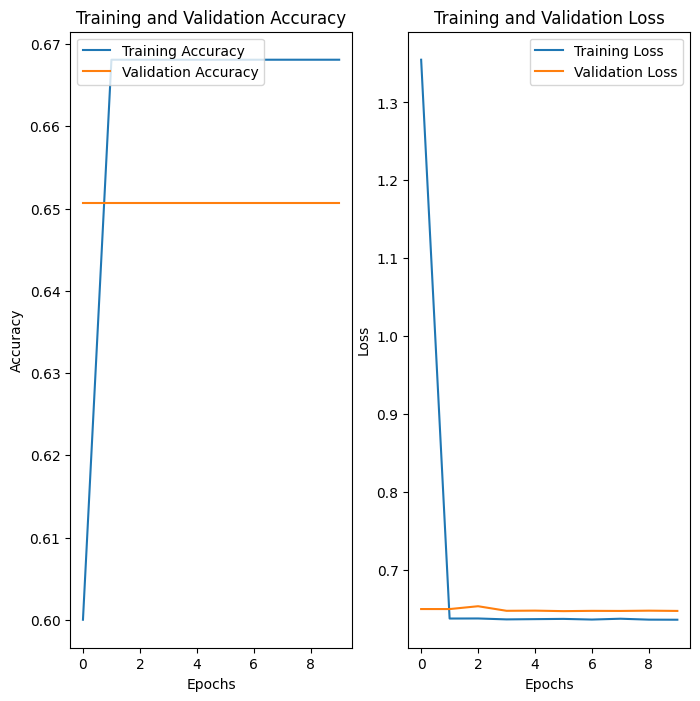

In [13]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


61/61 [==============================] - 1s 10ms/step
{'f1': 0.0, 'precision': 0.0, 'recall': 0.0}


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


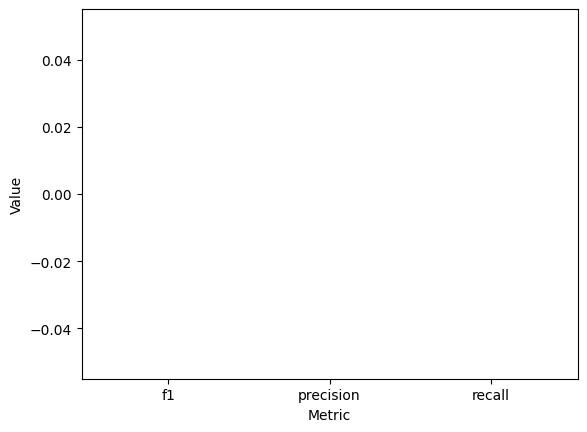

In [14]:
# Make predictions on validation data
val_pred = model.predict(val)
val_pred = np.round(val_pred)
val_pred = val_pred.flatten()

# Calculate metrics
f1 = f1_score(val_y, val_pred)
precision = precision_score(val_y, val_pred)
recall = recall_score(val_y, val_pred)

# Create a dictionary of metrics
metrics = {'f1':f1, 'precision':precision, 'recall':recall}

# Print metrics
print(metrics)

# Plot the metrics in a bar chart
import matplotlib.pyplot as plt

plt.bar(metrics.keys(), metrics.values())
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()


In [15]:
ben_test = os.listdir('benign_test')
mal_test = os.listdir('malignant_test')

In [16]:
test = []
test_y = []
for i in ben_test:
    x = 'benign_test/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(200,200))
    img = img/255 # normalising 
    test.append(img)
    test_y.append(0)
for i in mal_test:
    x = 'malignant_test/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(200,200))
    img = img/255 # normalising 
    test.append(img)
    test_y.append(1)
test = np.array(test)
encoder = LabelEncoder()
encoder.fit(test_y)
## encoder = to_categorical(encoder.fit_transform(test_y))
test_y = encoder.transform(test_y)
loss,acc = model.evaluate(test, test_y,verbose=2)
print('Accuracy on test data: '+ str(acc))
print('Loss on test data: ' + str(loss))

21/21 - 0s - loss: 0.7162 - accuracy: 0.5455 - 356ms/epoch - 17ms/step
Accuracy on test data: 0.5454545617103577
Loss on test data: 0.716204047203064


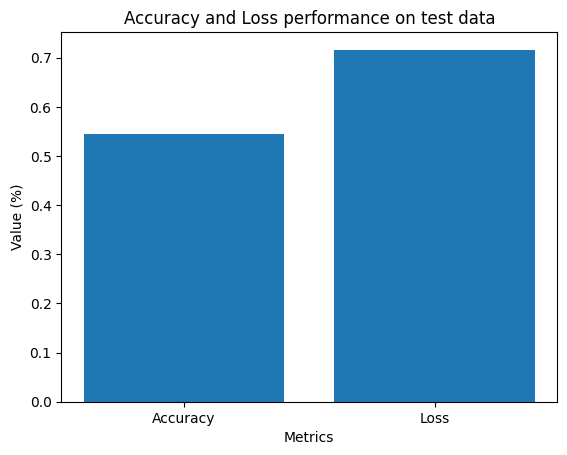

In [17]:
# Create a bar chart
plt.bar(['Accuracy', 'Loss'], [acc, loss])

# Add labels to the x and y axis
plt.xlabel('Metrics')
plt.ylabel('Value (%)')
plt.title("Accuracy and Loss performance on test data")

# Show the plot
plt.show()

In [18]:
predictions = model.predict(test)
predictions = (predictions >= 0.5).astype(int)
actual = test_y

21/21 [==============================] - 0s 11ms/step


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

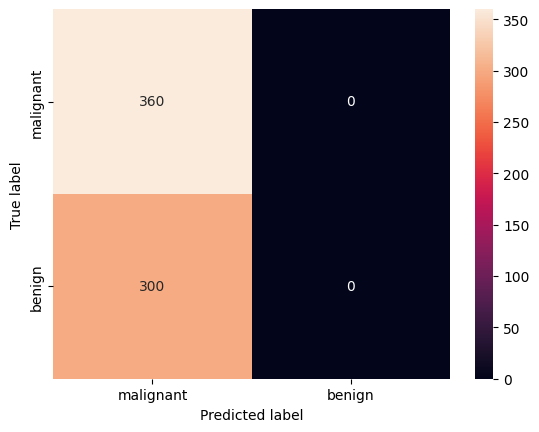

In [20]:
cm = confusion_matrix(actual, predictions)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['malignant', 'benign'], yticklabels=['malignant', 'benign'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()